# Data Science Project - Phase 2
## Team 4

The first goal in phase 2 of the Data Science project is to convert the daily number of COVID-19 new cases and deaths to a weekly format. We need to first import required libraries and read the csv files.

In [1]:
import os
import numpy as np
import pandas as pd
import time
from datetime import datetime
import plotly.express as px
from IPython.display import Image


import warnings
warnings.filterwarnings('ignore')

Read the worldwide COVID-19 data available at https://ourworldindata.org/coronavirus-source-data.

Keep only the columns needed from both the datasets. 

In [2]:
f = pd.read_csv("../../../data/stage_2/owid-covid-data.csv") #worldwide COVID-19 data

In [3]:
#change the date column to a datetime variable
f['date']=pd.to_datetime(f['date'])
f.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


From the worldwide COVID-19 dataset, keep columns `iso_code`, `location`, `date`, `total_cases`, `total_deaths`, `population` and `population_density`.

In [4]:
#cols_to_keep = list("iso_code", "location", "date", "total_cases", "total_deaths", "population")
f.new = f[["iso_code", "location", "date", "total_cases", "total_deaths", "population","population_density"]]
f.new.head()

,iso_code,location,date,total_cases,total_deaths,population,population_density
0,AFG,Afghanistan,2020-02-24,5.0,NaN,39835428.0,54.422
1,AFG,Afghanistan,2020-02-25,5.0,NaN,39835428.0,54.422
2,AFG,Afghanistan,2020-02-26,5.0,NaN,39835428.0,54.422
3,AFG,Afghanistan,2020-02-27,5.0,NaN,39835428.0,54.422
4,AFG,Afghanistan,2020-02-28,5.0,NaN,39835428.0,54.422


### Data Management

From the worldwide COVID-19 dataset, retain data for countries with _population densities_ similar to that of the US. The countries chosen for comparison are Brazil, Democratic Republic of Congo, Iran, Mexico, Myanmar, South Africa and Spain.

Some of the countries chosen have no records of deaths before certain days in 2020. With this in view, data for all the eight countries chosen has been filtered by dates accordingly.

We will therefore, be analyzing weekly new cases and deaths for weeks starting from 03/22/2020 to 02/05/2022.

In order to compute weekly averages for the world data, first group the data by `iso_code` to group countries, then compute the differences amongst `total_cases` and `total_deaths` column values for dates from 03/21/2020 to 02/05/2022. Once the differences have been computed, delete the row corresponding to the date 03/21/2020. Save the daily data with new cases and deaths generated.

(NOTE: We use values for 03/21/2020 to compute new cases and deaths for 03/22/2020 which is when we start our analysis).

In [5]:
#remove rows with dates earlier than March 21, 2020 (Saturday)
f_1 = f.new[~(f.new['date'] < '2020-03-21')]
#remove rows with dates later than February 5, 2022 (Saturday)
f_2 = f_1[~(f_1['date'] > '2022-02-05')]
f_2.head()

,iso_code,location,date,total_cases,total_deaths,population,population_density
26,AFG,Afghanistan,2020-03-21,24.0,NaN,39835428.0,54.422
27,AFG,Afghanistan,2020-03-22,34.0,NaN,39835428.0,54.422
28,AFG,Afghanistan,2020-03-23,40.0,1.0,39835428.0,54.422
29,AFG,Afghanistan,2020-03-24,42.0,1.0,39835428.0,54.422
30,AFG,Afghanistan,2020-03-25,74.0,1.0,39835428.0,54.422


In [6]:
#make a copy of the dataset
dt = f_2.copy()
dt = dt.reset_index(drop=True)
dt.head()

,iso_code,location,date,total_cases,total_deaths,population,population_density
0,AFG,Afghanistan,2020-03-21,24.0,NaN,39835428.0,54.422
1,AFG,Afghanistan,2020-03-22,34.0,NaN,39835428.0,54.422
2,AFG,Afghanistan,2020-03-23,40.0,1.0,39835428.0,54.422
3,AFG,Afghanistan,2020-03-24,42.0,1.0,39835428.0,54.422
4,AFG,Afghanistan,2020-03-25,74.0,1.0,39835428.0,54.422


**I) Compiling data for the USA**

In [7]:
#subset data for the USA
dt_USA = dt[dt['iso_code']=='USA'].reset_index(drop=True)
#compute new cases each day
dt_USA['new_cases'] = dt_USA['total_cases'].diff()
#compute number of deaths each day
dt_USA['num_deaths'] = dt_USA['total_deaths'].diff()
#drop the date 03/21/2020
dt_USA = dt_USA.drop(0)
dt_USA = dt_USA.drop(columns=["total_cases", "total_deaths"])
USA_pop = dt_USA.population[1]
dt_USA.head()

,iso_code,location,date,population,population_density,new_cases,num_deaths
1,USA,United States,2020-03-22,332915074.0,35.608,8919.0,128.0
2,USA,United States,2020-03-23,332915074.0,35.608,11152.0,187.0
3,USA,United States,2020-03-24,332915074.0,35.608,10618.0,243.0
4,USA,United States,2020-03-25,332915074.0,35.608,12127.0,333.0
5,USA,United States,2020-03-26,332915074.0,35.608,17821.0,417.0


In [8]:
#drop pop and pop density columns
dt_USA = dt_USA.drop(columns=["population","population_density"]) 

#resampling to weekly data
dt_USA_weekly_avg= dt_USA.groupby(['iso_code','location',pd.Grouper(key='date', freq='w')])['new_cases','num_deaths'].agg({'new_cases':'mean','num_deaths' :'mean'}).reset_index().round(decimals=0)
dt_USA_weekly_avg

,iso_code,location,date,new_cases,num_deaths
0,USA,United States,2020-03-22,8919.0,128.0
1,USA,United States,2020-03-29,15514.0,424.0
2,USA,United States,2020-04-05,29346.0,1317.0
3,USA,United States,2020-04-12,31164.0,2127.0
4,USA,United States,2020-04-19,28098.0,2179.0
...,...,...,...,...,...
94,USA,United States,2022-01-09,722905.0,1715.0
95,USA,United States,2022-01-16,801386.0,1975.0
96,USA,United States,2022-01-23,707167.0,2160.0
97,USA,United States,2022-01-30,508906.0,2471.0


In [9]:
dt_USA_weekly_avg.describe()

,new_cases,num_deaths
count,99.000000,99.000000
mean,110843.838384,1309.232323
std,140223.786727,784.051667
min,8919.000000,128.000000
25%,37892.000000,728.000000
50%,65611.000000,1116.000000
75%,133179.500000,1726.500000
max,801386.000000,3345.000000


## Rounding the values of mean and median

#### Rounding mean:

In [10]:
dt_USA_weekly_avg[['new_cases','num_deaths']].agg(['mean']).round(decimals=0)

,new_cases,num_deaths
mean,110844.0,1309.0


#### Rounding median:

In [11]:
dt_USA_weekly_avg[['new_cases','num_deaths']].agg(['median']).round(decimals=0)

,new_cases,num_deaths
median,65611.0,1116.0


#### Mode:

In [12]:
mode = dt_USA_weekly_avg.loc[:,"new_cases"].mode()
mode_deaths = dt_USA_weekly_avg.loc[:,"num_deaths"].mode()
print('The mode of new cases is', mode[0])
print('The mode of new deaths is',mode_deaths[0])

The mode of new cases is 8919.0
The mode of new deaths is 820.0


In [15]:
#drop pop and pop density columns
#dt_USA = dt_USA.drop(columns=["population","population_density"]) 

#resampling to weekly data
dt_USA_weekly_avg= dt_USA.groupby(['iso_code','location',pd.Grouper(key='date', freq='w')])['new_cases','num_deaths'].agg({'new_cases':'mean','num_deaths' :'mean'}).reset_index().round(decimals=0)
dt_USA_weekly_avg

,iso_code,location,date,new_cases,num_deaths
0,USA,United States,2020-03-22,8919.0,128.0
1,USA,United States,2020-03-29,15514.0,424.0
2,USA,United States,2020-04-05,29346.0,1317.0
3,USA,United States,2020-04-12,31164.0,2127.0
4,USA,United States,2020-04-19,28098.0,2179.0
...,...,...,...,...,...
94,USA,United States,2022-01-09,722905.0,1715.0
95,USA,United States,2022-01-16,801386.0,1975.0
96,USA,United States,2022-01-23,707167.0,2160.0
97,USA,United States,2022-01-30,508906.0,2471.0


### Normalizing counts (number of counts per 100,000 persons)

In [16]:
dt_USA_weekly_avg['new_cases_per_100000'] = dt_USA_weekly_avg.new_cases/USA_pop *100000
dt_USA_weekly_avg['num_deaths_per_100000'] = dt_USA_weekly_avg.num_deaths/USA_pop *100000
#log normalized values (base 10 log)
dt_USA_weekly_avg['lognormal_cases'] = np.log10(dt_USA_weekly_avg.new_cases_per_100000)
dt_USA_weekly_avg['lognormal_deaths'] = np.log10(dt_USA_weekly_avg.num_deaths_per_100000)
dt_USA_weekly_avg.head()

,iso_code,location,date,new_cases,num_deaths,new_cases_per_100000,num_deaths_per_100000,lognormal_cases,lognormal_deaths
0,USA,United States,2020-03-22,8919.0,128.0,2.679062,0.038448,0.427983,-1.415123
1,USA,United States,2020-03-29,15514.0,424.0,4.660047,0.127360,0.668390,-0.894968
2,USA,United States,2020-04-05,29346.0,1317.0,8.814861,0.395596,0.945215,-0.402748
3,USA,United States,2020-04-12,31164.0,2127.0,9.360946,0.638902,0.971320,-0.194566
4,USA,United States,2020-04-19,28098.0,2179.0,8.439990,0.654521,0.926342,-0.184076


### Plot interactive plot for the weekly averages, normalized counts and log normalized counts of new cases and deaths.

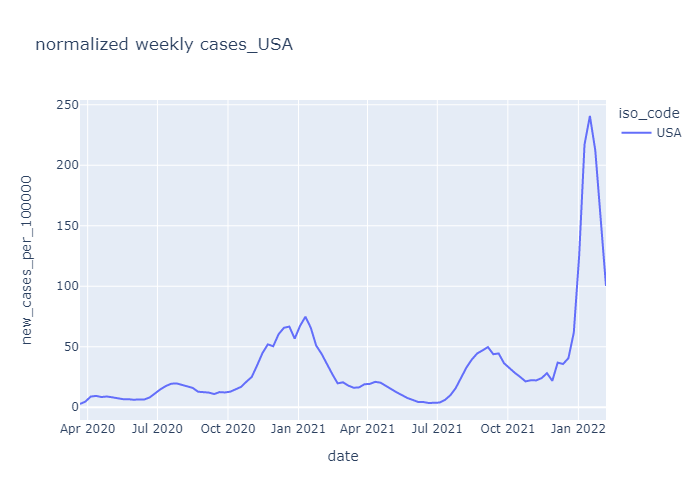

In [17]:
fig = px.line(dt_USA_weekly_avg, x="date", y="new_cases_per_100000", color="iso_code",
              line_group="iso_code", hover_name="iso_code", title ='normalized weekly cases_USA')
#display plot
fig.write_image("Team4/normalized weekly cases_USA.png")
Image(filename="Team4/normalized weekly cases_USA.png")
#fig.show()

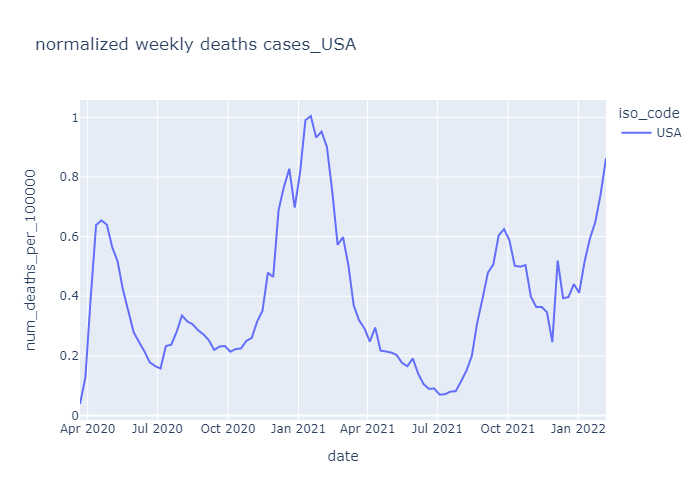

In [18]:
fig = px.line(dt_USA_weekly_avg, x="date", y="num_deaths_per_100000", color="iso_code",
              line_group="iso_code", hover_name="iso_code", title ='normalized weekly deaths cases_USA')
#display plot
fig.write_image("Team4/normalized weekly deaths cases_USA.png")
Image(filename="Team4/normalized weekly deaths cases_USA.png")
#fig.show()

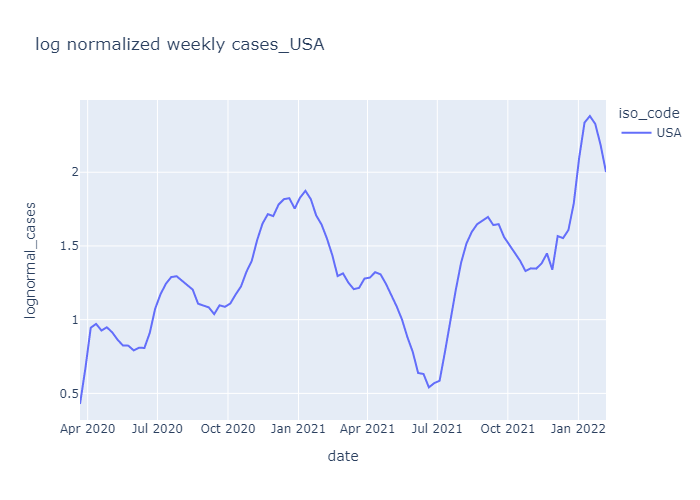

In [19]:
fig = px.line(dt_USA_weekly_avg, x="date", y="lognormal_cases", color="iso_code",
              line_group="iso_code", hover_name="iso_code", title ='log normalized weekly cases_USA')
#display plot
fig.write_image("Team4/log normalized weekly cases_USA.png")
Image(filename="Team4/log normalized weekly cases_USA.png")
#fig.show()

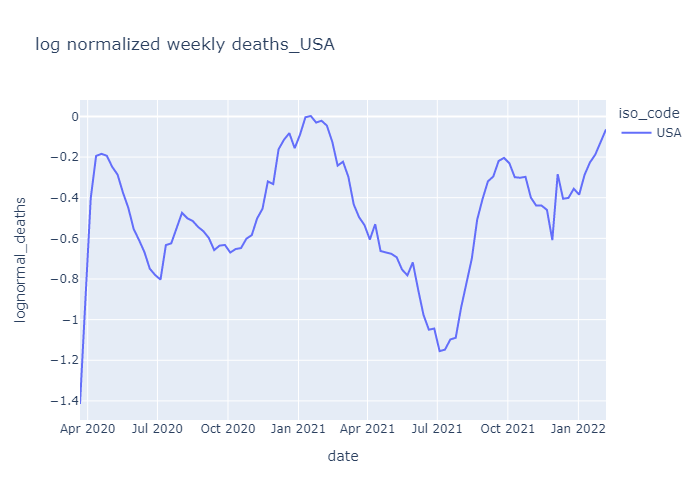

In [20]:
fig = px.line(dt_USA_weekly_avg, x="date", y="lognormal_deaths", color="iso_code",
              line_group="iso_code", hover_name="iso_code", title ='log normalized weekly deaths_USA')
#display plot
fig.write_image("Team4/log normalized weekly deaths_USA.png")
Image(filename="Team4/log normalized weekly deaths_USA.png")
#fig.show()

## Inference from the plots:
### USA:
* There are three peaks in COVID-19 cases in December 2020-January 2021, August 2021 and January 2022. These seem to coincide with the peaks before the rollout of vaccines started in the United States in January 2021, the resumption of in-person classes in educational institutions and the third peak (which is the highest) with the rapid rise in cases due to the spread of the infectious Omicron variant.
* COVID-19 deaths have had multiple peaks as seen in April-May 2020 which saw a huge spike in certain areas of the country as the virus first started spreading. There are subsequent peaks, some of which are not very high. The deaths rose to the maximum in January 2021 and saw a decline after the rollout of the vaccines. Deaths peaked again around October 2021 in the US (which follows the spike in cases in September 2021 and is as high as the first spike noted in COVID-19 deaths) probably because of a general disregard for the safety protocols. Post this spike, it started to decline before reaching a peak again in January 2022, which can be attributed to the Omicron variant.


**Compiling data for Brazil**

In [21]:
#subset data for Brazil
dt_BRA = dt[dt['iso_code']=='BRA'].reset_index(drop=True)
#compute new cases each day
dt_BRA['new_cases'] = dt_BRA['total_cases'].diff()
#compute number of deaths each day
dt_BRA['num_deaths'] = dt_BRA['total_deaths'].diff()
#drop the date 03/21/2020
dt_BRA = dt_BRA.drop(0)
dt_BRA = dt_BRA.drop(columns=["total_cases", "total_deaths"])
BRA_pop = dt_BRA.population[1]
dt_BRA

,iso_code,location,date,population,population_density,new_cases,num_deaths
1,BRA,Brazil,2020-03-22,213993441.0,25.04,525.0,10.0
2,BRA,Brazil,2020-03-23,213993441.0,25.04,378.0,9.0
3,BRA,Brazil,2020-03-24,213993441.0,25.04,323.0,12.0
4,BRA,Brazil,2020-03-25,213993441.0,25.04,307.0,13.0
5,BRA,Brazil,2020-03-26,213993441.0,25.04,431.0,18.0
...,...,...,...,...,...,...,...
682,BRA,Brazil,2022-02-01,213993441.0,25.04,171251.0,767.0
683,BRA,Brazil,2022-02-02,213993441.0,25.04,185964.0,945.0
684,BRA,Brazil,2022-02-03,213993441.0,25.04,287149.0,1000.0
685,BRA,Brazil,2022-02-04,213993441.0,25.04,218560.0,964.0


In [22]:
dt_BRA = dt_BRA.drop(columns=["population","population_density"]) 
#resampling to weekly data

dt_BRA_weekly_avg= dt_BRA.groupby(['iso_code','location',pd.Grouper(key='date', freq='w')])['new_cases','num_deaths'].agg({'new_cases':'mean','num_deaths' :'mean'}).reset_index().round(decimals=0)
dt_BRA_weekly_avg

,iso_code,location,date,new_cases,num_deaths
0,BRA,Brazil,2020-03-22,525.0,10.0
1,BRA,Brazil,2020-03-29,387.0,16.0
2,BRA,Brazil,2020-04-05,982.0,50.0
3,BRA,Brazil,2020-04-12,1580.0,105.0
4,BRA,Brazil,2020-04-19,2352.0,177.0
...,...,...,...,...,...
94,BRA,Brazil,2022-01-09,33108.0,121.0
95,BRA,Brazil,2022-01-16,69421.0,154.0
96,BRA,Brazil,2022-01-23,148468.0,292.0
97,BRA,Brazil,2022-01-30,186606.0,540.0


In [23]:
dt_BRA_weekly_avg['new_cases_per_100000'] = dt_BRA_weekly_avg.new_cases/BRA_pop *100000
dt_BRA_weekly_avg['num_deaths_per_100000'] = dt_BRA_weekly_avg.num_deaths/BRA_pop *100000
#log normalized values (base 10 log)
dt_BRA_weekly_avg['lognormal_cases'] = np.log10(dt_BRA_weekly_avg.new_cases_per_100000)
dt_BRA_weekly_avg['lognormal_deaths'] = np.log10(dt_BRA_weekly_avg.num_deaths_per_100000)
dt_BRA_weekly_avg.head()

,iso_code,location,date,new_cases,num_deaths,new_cases_per_100000,num_deaths_per_100000,lognormal_cases,lognormal_deaths
0,BRA,Brazil,2020-03-22,525.0,10.0,0.245335,0.004673,-0.610241,-2.330400
1,BRA,Brazil,2020-03-29,387.0,16.0,0.180847,0.007477,-0.742689,-2.126280
2,BRA,Brazil,2020-04-05,982.0,50.0,0.458893,0.023365,-0.338289,-1.631430
3,BRA,Brazil,2020-04-12,1580.0,105.0,0.738340,0.049067,-0.131743,-1.309211
4,BRA,Brazil,2020-04-19,2352.0,177.0,1.099099,0.082713,0.041037,-1.082427


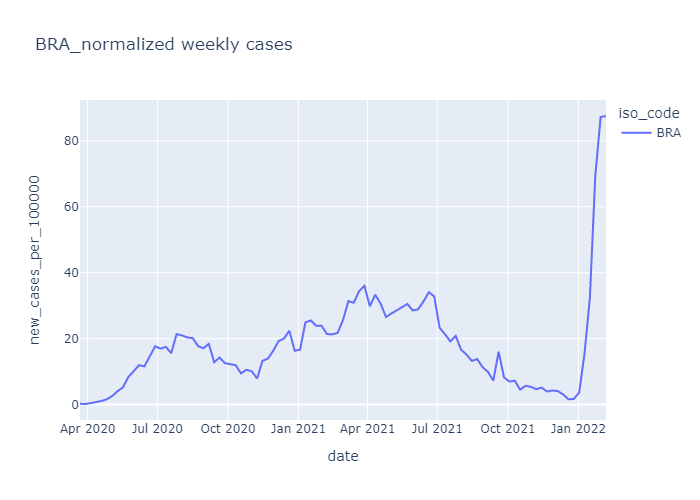

In [24]:
fig = px.line(dt_BRA_weekly_avg, x="date", y="new_cases_per_100000", color="iso_code",
              line_group="iso_code", hover_name="iso_code", title ='BRA_normalized weekly cases')
#display plot
fig.write_image("Team4/BRA_normalized weekly cases.png")
Image(filename="Team4/BRA_normalized weekly cases.png")
#fig.show()

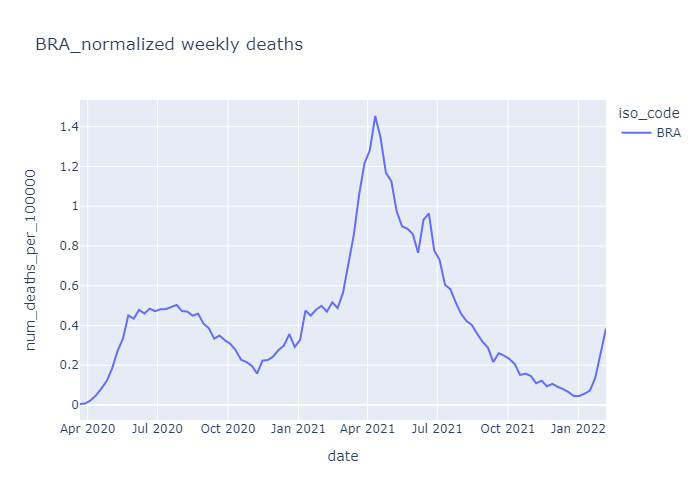

In [25]:
fig = px.line(dt_BRA_weekly_avg, x="date", y="num_deaths_per_100000", color="iso_code",
              line_group="iso_code", hover_name="iso_code", title ='BRA_normalized weekly deaths')
#display plot
fig.write_image("Team4/BRA_normalized weekly deaths.png")
Image(filename="Team4/BRA_normalized weekly deaths.png")
#fig.show()

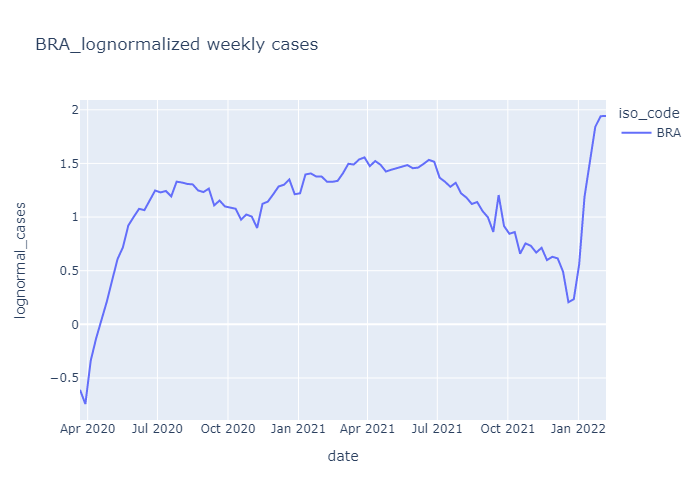

In [26]:
fig = px.line(dt_BRA_weekly_avg, x="date", y="lognormal_cases", color="iso_code",
              line_group="iso_code", hover_name="iso_code", title ='BRA_lognormalized weekly cases')
#display plot
fig.write_image("Team4/BRA_lognormalized weekly cases.png")
Image(filename="Team4/BRA_lognormalized weekly cases.png")
#fig.show()

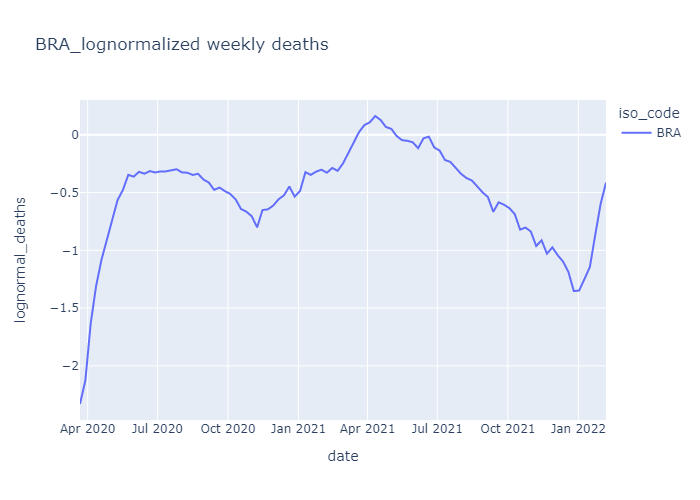

In [27]:
fig = px.line(dt_BRA_weekly_avg, x="date", y="lognormal_deaths", color="iso_code",
              line_group="iso_code", hover_name="iso_code", title ='BRA_lognormalized weekly deaths')
#display plot
fig.write_image("Team4/BRA_lognormalized weekly deaths.png")
Image(filename="Team4/BRA_lognormalized weekly deaths.png")
#fig.show()

## Inference from the plots:

### Brazil
* In Brazil, the first noticeable peak in covid cases occured in the month of August 2020 which starts declining by October 2020. The peak occurred because of the covid outspread in winter months(June to September) in the southern hemisphere and a high number of covid testing. So the number of cases and deaths increased.
* From September 2020 cases again started increasing and reached their second peak in the month of April 2021. The cases are much higher than the first wave because of the Delta variant. Also, a huge peak can be been in the number of deaths because of this.
* This second wave effect went on until July 2021 after which cases started decreasing.
* In January 2022, cases started increasing and reached their peak because of the new omicron variant. But as a large population is vaccinated in Brazil so we see no high peak in the number of deaths.
* Compared to the USA, Brazil has fewer cases and deaths and the trend is different than US. Just the peak in the month of January 2022 is the same. Moreover, Brazil has cases peaks going thorughout the plot.

**Compiling data for DR of Congo**

In [28]:
#subset data for DR Congo
dt_COD = dt[dt['iso_code']=='COD'].reset_index(drop=True)
#compute new cases each day
dt_COD['new_cases'] = dt_COD['total_cases'].diff()
#compute number of deaths each day
dt_COD['num_deaths'] = dt_COD['total_deaths'].diff()
#drop the date 03/21/2020
dt_COD = dt_COD.drop(0)
dt_COD = dt_COD.drop(columns=["total_cases", "total_deaths"])
COD_pop = dt_COD.population[1]
dt_COD

,iso_code,location,date,population,population_density,new_cases,num_deaths
1,COD,Democratic Republic of Congo,2020-03-22,92377986.0,35.879,7.0,0.0
2,COD,Democratic Republic of Congo,2020-03-23,92377986.0,35.879,6.0,0.0
3,COD,Democratic Republic of Congo,2020-03-24,92377986.0,35.879,9.0,1.0
4,COD,Democratic Republic of Congo,2020-03-25,92377986.0,35.879,3.0,0.0
5,COD,Democratic Republic of Congo,2020-03-26,92377986.0,35.879,3.0,1.0
...,...,...,...,...,...,...,...
682,COD,Democratic Republic of Congo,2022-02-01,92377986.0,35.879,0.0,0.0
683,COD,Democratic Republic of Congo,2022-02-02,92377986.0,35.879,131.0,0.0
684,COD,Democratic Republic of Congo,2022-02-03,92377986.0,35.879,0.0,0.0
685,COD,Democratic Republic of Congo,2022-02-04,92377986.0,35.879,0.0,0.0


In [29]:
dt_COD = dt_COD.drop(columns=["population","population_density"]) 

#resampling to weekly data
dt_COD_weekly_avg= dt_COD.groupby(['iso_code','location',pd.Grouper(key='date', freq='w')])['new_cases','num_deaths'].agg({'new_cases':'mean','num_deaths' :'mean'}).reset_index().round(decimals=0)
dt_COD_weekly_avg

,iso_code,location,date,new_cases,num_deaths
0,COD,Democratic Republic of Congo,2020-03-22,7.0,0.0
1,COD,Democratic Republic of Congo,2020-03-29,5.0,1.0
2,COD,Democratic Republic of Congo,2020-04-05,13.0,2.0
3,COD,Democratic Republic of Congo,2020-04-12,11.0,0.0
4,COD,Democratic Republic of Congo,2020-04-19,13.0,1.0
...,...,...,...,...,...
94,COD,Democratic Republic of Congo,2022-01-09,769.0,3.0
95,COD,Democratic Republic of Congo,2022-01-16,304.0,0.0
96,COD,Democratic Republic of Congo,2022-01-23,282.0,8.0
97,COD,Democratic Republic of Congo,2022-01-30,102.0,0.0


In [30]:
dt_COD_weekly_avg['new_cases_per_100000'] = dt_COD_weekly_avg.new_cases/COD_pop *100000
dt_COD_weekly_avg['num_deaths_per_100000'] = dt_COD_weekly_avg.num_deaths/COD_pop *100000
#log normalized values (base 10 log)
dt_COD_weekly_avg['lognormal_cases'] = np.log10(dt_COD_weekly_avg.new_cases_per_100000)
dt_COD_weekly_avg['lognormal_deaths'] = np.log10(dt_COD_weekly_avg.num_deaths_per_100000)
dt_COD_weekly_avg.head()

,iso_code,location,date,new_cases,num_deaths,new_cases_per_100000,num_deaths_per_100000,lognormal_cases,lognormal_deaths
0,COD,Democratic Republic of Congo,2020-03-22,7.0,0.0,0.007578,0.000000,-2.120470,-inf
1,COD,Democratic Republic of Congo,2020-03-29,5.0,1.0,0.005413,0.001083,-2.266598,-2.965568
2,COD,Democratic Republic of Congo,2020-04-05,13.0,2.0,0.014073,0.002165,-1.851625,-2.664538
3,COD,Democratic Republic of Congo,2020-04-12,11.0,0.0,0.011908,0.000000,-1.924176,-inf
4,COD,Democratic Republic of Congo,2020-04-19,13.0,1.0,0.014073,0.001083,-1.851625,-2.965568


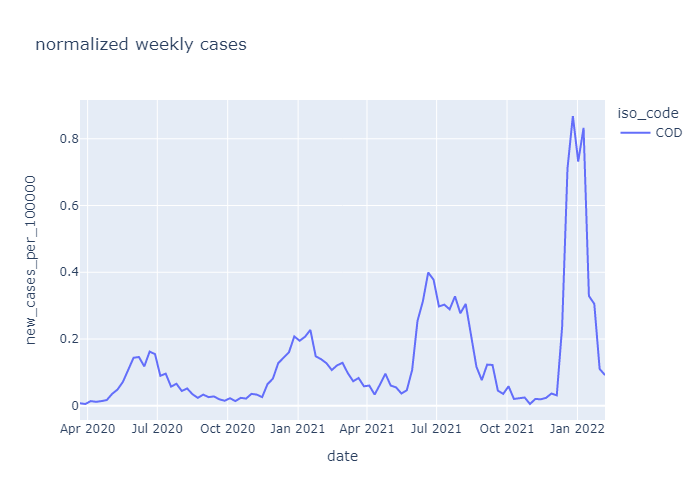

In [31]:
fig = px.line(dt_COD_weekly_avg, x="date", y="new_cases_per_100000", color="iso_code",
              line_group="iso_code", hover_name="iso_code", title ='normalized weekly cases')
#display plot
fig.write_image("Team4/normalized weekly cases_COD.png")
Image(filename="Team4/normalized weekly cases_COD.png")
#fig.show()

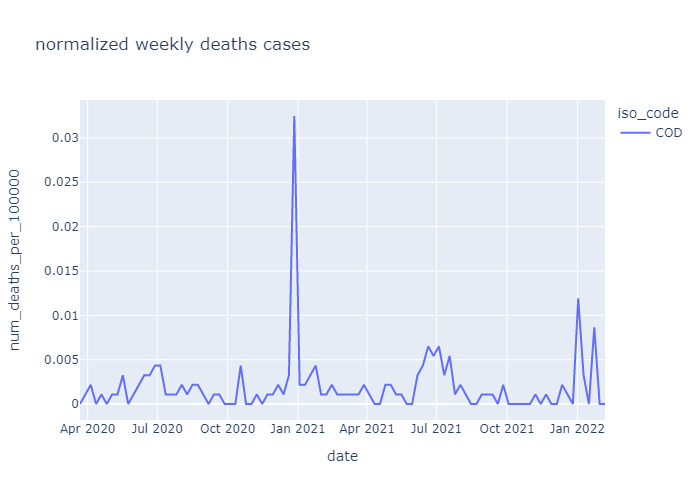

In [32]:
fig = px.line(dt_COD_weekly_avg, x="date", y="num_deaths_per_100000", color="iso_code",
              line_group="iso_code", hover_name="iso_code", title ='normalized weekly deaths cases')
#display plot
fig.write_image("Team4/normalized weekly deaths cases_COD.png")
Image(filename="Team4/normalized weekly deaths cases_COD.png")
#fig.show()

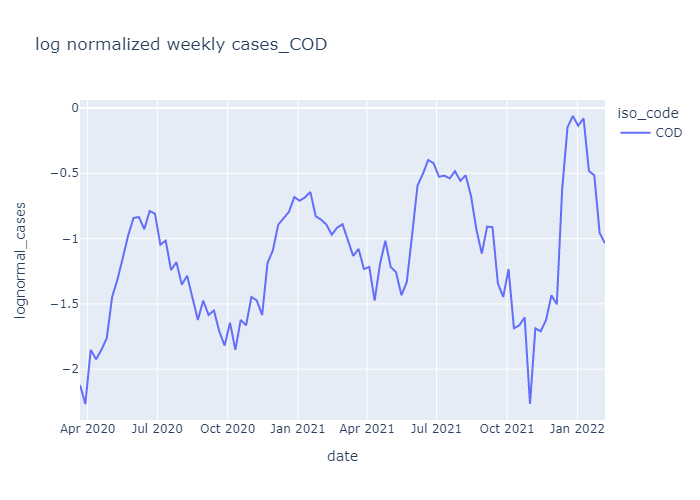

In [33]:
fig = px.line(dt_COD_weekly_avg, x="date", y="lognormal_cases", color="iso_code",
              line_group="iso_code", hover_name="iso_code", title ='log normalized weekly cases_COD')
#display plot
fig.write_image("Team4/log normalized weekly cases_COD.png")
Image(filename="Team4/log normalized weekly cases_COD.png")
#fig.show()


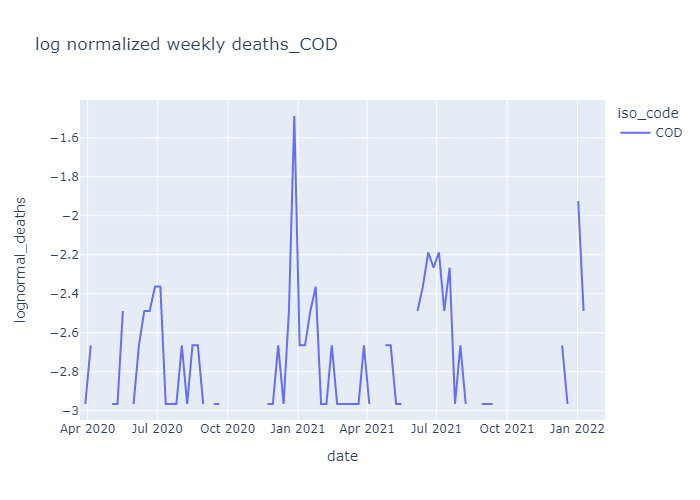

In [34]:
fig = px.line(dt_COD_weekly_avg, x="date", y="lognormal_deaths", color="iso_code",
              line_group="iso_code", hover_name="iso_code", title ='log normalized weekly deaths_COD')
#display plot
fig.write_image("Team4/log normalized weekly deaths_COD.png")
Image(filename="Team4/log normalized weekly deaths_COD.png")
#fig.show()

## Inference from the plots:

### Democratic Republic of Congo
* The normalized weekly COVID-19 cases (per 100,000 persons) were much lower than that of the United States. There were peaks in cases in May-June 2020, January 2021, July 2021 followed by a huge spike in December 2021 and January 2022. As per the WHO, this increase was part of an Africa-wide surge that saw weekly COVID cases spike 83 percent in mid-December, driven by the Delta and Omicron variants, although deaths remained low.
* Deaths due to COVID-19 are also considerably lower (per 100,000 persons) when compared with the US. Death counts increase and decreases randomly throughout the period. There was a sharp peak in deaths in December 2020, after which the deaths dipped and there were again peaks in July 2021 and January 2022, although they weren’t as sharp as the rise in December 2020.
* Despite the commencement of vaccination in April 2021, the Democratic Republic of Congo has been reported to be the least vaccinated country in the world. 

**Compiling data for Iran**

In [35]:
#subset data for Iran
dt_IRN = dt[dt['iso_code']=='IRN'].reset_index(drop=True)
#compute new cases each day
dt_IRN['new_cases'] = dt_IRN['total_cases'].diff()
#compute number of deaths each day
dt_IRN['num_deaths'] = dt_IRN['total_deaths'].diff()
#drop the date 03/21/2020
dt_IRN = dt_IRN.drop(0)
dt_IRN = dt_IRN.drop(columns=["total_cases", "total_deaths"])
IRN_pop = dt_IRN.population[1]
dt_IRN

,iso_code,location,date,population,population_density,new_cases,num_deaths
1,IRN,Iran,2020-03-22,85028760.0,49.831,1028.0,129.0
2,IRN,Iran,2020-03-23,85028760.0,49.831,1411.0,127.0
3,IRN,Iran,2020-03-24,85028760.0,49.831,1762.0,122.0
4,IRN,Iran,2020-03-25,85028760.0,49.831,2206.0,143.0
5,IRN,Iran,2020-03-26,85028760.0,49.831,2389.0,157.0
...,...,...,...,...,...,...,...
682,IRN,Iran,2022-02-01,85028760.0,49.831,35070.0,50.0
683,IRN,Iran,2022-02-02,85028760.0,49.831,38160.0,59.0
684,IRN,Iran,2022-02-03,85028760.0,49.831,37395.0,61.0
685,IRN,Iran,2022-02-04,85028760.0,49.831,36908.0,57.0


In [36]:
dt_IRN = dt_IRN.drop(columns=["population","population_density"]) 

#resampling to weekly data
dt_IRN_weekly_avg= dt_IRN.groupby(['iso_code','location',pd.Grouper(key='date', freq='w')])['new_cases','num_deaths'].agg({'new_cases':'mean','num_deaths' :'mean'}).reset_index().round(decimals=0)
dt_IRN_weekly_avg

,iso_code,location,date,new_cases,num_deaths
0,IRN,Iran,2020-03-22,1028.0,129.0
1,IRN,Iran,2020-03-29,2382.0,136.0
2,IRN,Iran,2020-04-05,2845.0,138.0
3,IRN,Iran,2020-04-12,1923.0,124.0
4,IRN,Iran,2020-04-19,1504.0,92.0
...,...,...,...,...,...
94,IRN,Iran,2022-01-09,1356.0,28.0
95,IRN,Iran,2022-01-16,2090.0,28.0
96,IRN,Iran,2022-01-23,4208.0,22.0
97,IRN,Iran,2022-01-30,13384.0,28.0


In [37]:
dt_IRN_weekly_avg['new_cases_per_100000'] = dt_IRN_weekly_avg.new_cases/IRN_pop *100000
dt_IRN_weekly_avg['num_deaths_per_100000'] = dt_IRN_weekly_avg.num_deaths/IRN_pop *100000
#log normalized values (base 10 log)
dt_IRN_weekly_avg['lognormal_cases'] = np.log10(dt_IRN_weekly_avg.new_cases_per_100000)
dt_IRN_weekly_avg['lognormal_deaths'] = np.log10(dt_IRN_weekly_avg.num_deaths_per_100000)
dt_IRN_weekly_avg.head()

,iso_code,location,date,new_cases,num_deaths,new_cases_per_100000,num_deaths_per_100000,lognormal_cases,lognormal_deaths
0,IRN,Iran,2020-03-22,1028.0,129.0,1.209003,0.151713,0.082427,-0.818976
1,IRN,Iran,2020-03-29,2382.0,136.0,2.801405,0.159946,0.447376,-0.796027
2,IRN,Iran,2020-04-05,2845.0,138.0,3.345927,0.162298,0.524516,-0.789687
3,IRN,Iran,2020-04-12,1923.0,124.0,2.261588,0.145833,0.354413,-0.836144
4,IRN,Iran,2020-04-19,1504.0,92.0,1.768813,0.108199,0.247682,-0.965778


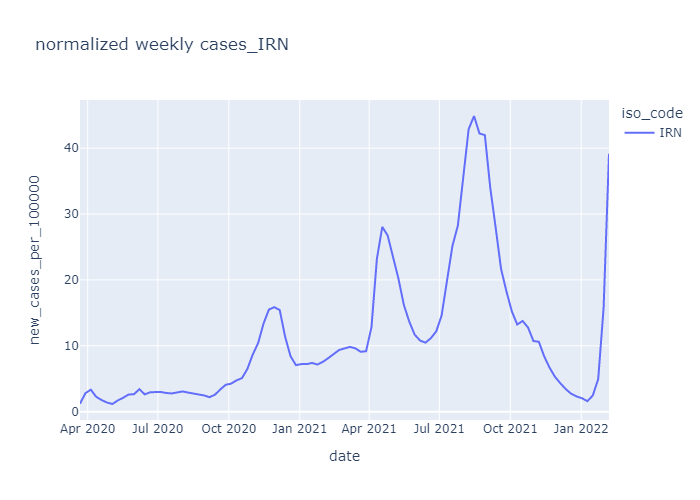

In [38]:
fig = px.line(dt_IRN_weekly_avg, x="date", y="new_cases_per_100000", color="iso_code",
              line_group="iso_code", hover_name="iso_code", title ='normalized weekly cases_IRN')
#display plot
fig.write_image("Team4/normalized weekly cases_IRN.png")
Image(filename="Team4/normalized weekly cases_IRN.png")
#fig.show()


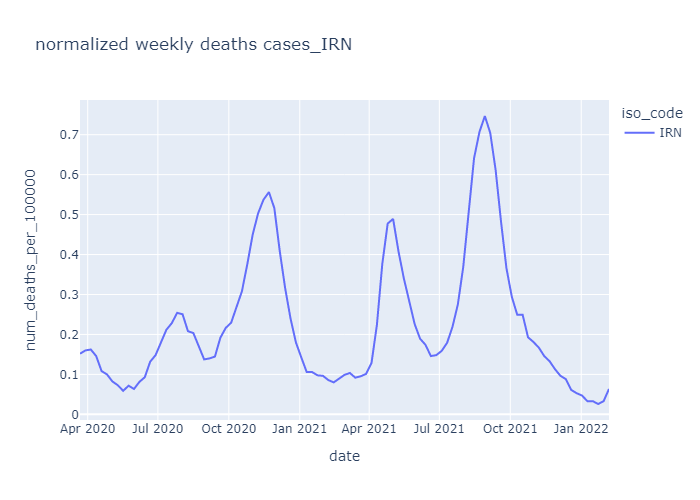

In [39]:
fig = px.line(dt_IRN_weekly_avg, x="date", y="num_deaths_per_100000", color="iso_code",
              line_group="iso_code", hover_name="iso_code", title ='normalized weekly deaths cases_IRN')
#display plot
fig.write_image("Team4/normalized weekly deaths cases_IRN.png")
Image(filename="Team4/normalized weekly deaths cases_IRN.png")
#fig.show()


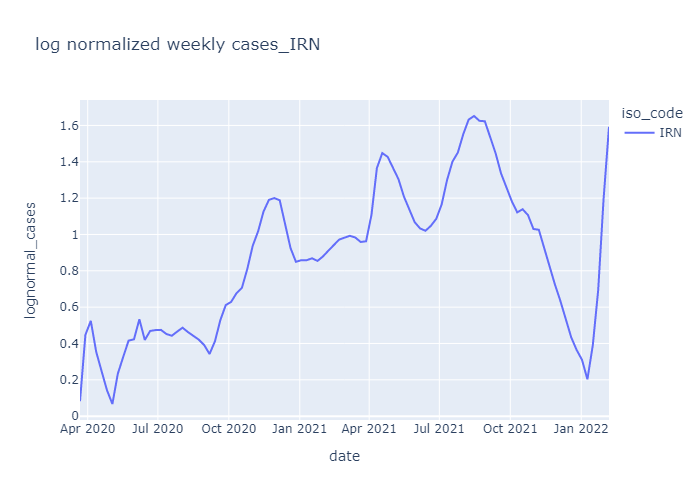

In [40]:
fig = px.line(dt_IRN_weekly_avg, x="date", y="lognormal_cases", color="iso_code",
              line_group="iso_code", hover_name="iso_code", title ='log normalized weekly cases_IRN')
#display plot
fig.write_image("Team4/log normalized weekly cases_IRN.png")
Image(filename="Team4/log normalized weekly cases_IRN.png")
#fig.show()

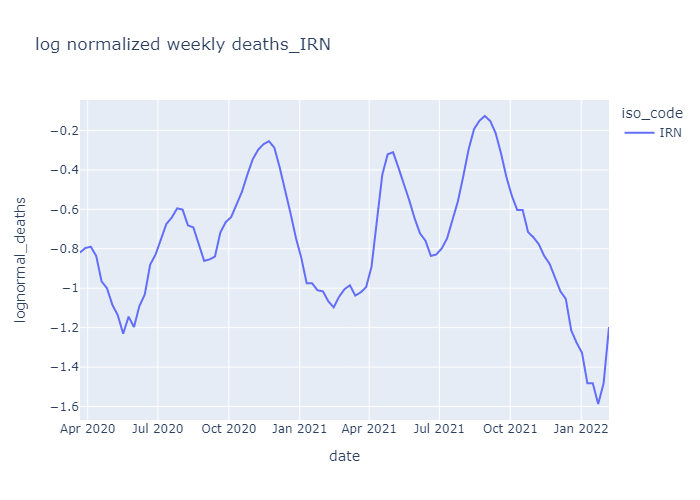

In [41]:
fig = px.line(dt_IRN_weekly_avg, x="date", y="lognormal_deaths", color="iso_code",
              line_group="iso_code", hover_name="iso_code", title ='log normalized weekly deaths_IRN')
#display plot
fig.write_image("Team4/log normalized weekly deaths_IRN.png")
Image(filename="Team4/log normalized weekly deaths_IRN.png")
#fig.show()

## Inference from the plot:
### Iran
* There was a large spike in COVID cases in late April/early May of 2021 that differs from other countries. It’s unclear what caused the spike, but it appears that Iranians as a whole were struggling to get vaccinated. The leader of Iran banned imports of American and British vaccines, meaning they had to get Russia’s or China’s vaccines instead. They had their own vaccines, but struggled to mass produce them. 
*By the time the Delta variant hit, only 2% of citizens were vaccinated. This can also be seen in the COVID deaths, where spikes occur roughly around the same time as each COVID case spike, with an equal amount of severity. This is different from other countries with higher vaccination rates. Lastly, it appears that the Omicron variant is currently hitting the country hard, with a current major spike in cases. Deaths are only now starting to uptick, but we’d anticipate seeing a similar spike soon.

**Compiling data for Mexico**

In [42]:
#subset data for Mexico
dt_MEX = dt[dt['iso_code']=='MEX'].reset_index(drop=True)
#compute new cases each day
dt_MEX['new_cases'] = dt_MEX['total_cases'].diff()
#compute number of deaths each day
dt_MEX['num_deaths'] = dt_MEX['total_deaths'].diff()
#drop the date 03/21/2020
dt_MEX = dt_MEX.drop(0)
dt_MEX = dt_MEX.drop(columns=["total_cases", "total_deaths"])
MEX_pop = dt_MEX.population[1]
dt_MEX

,iso_code,location,date,population,population_density,new_cases,num_deaths
1,MEX,Mexico,2020-03-22,130262220.0,66.444,65.0,1.0
2,MEX,Mexico,2020-03-23,130262220.0,66.444,51.0,1.0
3,MEX,Mexico,2020-03-24,130262220.0,66.444,38.0,1.0
4,MEX,Mexico,2020-03-25,130262220.0,66.444,70.0,1.0
5,MEX,Mexico,2020-03-26,130262220.0,66.444,110.0,2.0
...,...,...,...,...,...,...,...
682,MEX,Mexico,2022-02-01,130262220.0,66.444,43099.0,829.0
683,MEX,Mexico,2022-02-02,130262220.0,66.444,0.0,0.0
684,MEX,Mexico,2022-02-03,130262220.0,66.444,42181.0,573.0
685,MEX,Mexico,2022-02-04,130262220.0,66.444,78178.0,1336.0


In [43]:
dt_MEX = dt_MEX.drop(columns=["population","population_density"]) 
#resampling to weekly data
dt_MEX_weekly_avg= dt_MEX.groupby(['iso_code','location',pd.Grouper(key='date', freq='w')])['new_cases','num_deaths'].agg({'new_cases':'mean','num_deaths' :'mean'}).reset_index().round(decimals=0)
dt_MEX_weekly_avg

,iso_code,location,date,new_cases,num_deaths
0,MEX,Mexico,2020-03-22,65.0,1.0
1,MEX,Mexico,2020-03-29,97.0,2.0
2,MEX,Mexico,2020-04-05,164.0,11.0
3,MEX,Mexico,2020-04-12,360.0,29.0
4,MEX,Mexico,2020-04-19,514.0,56.0
...,...,...,...,...,...
94,MEX,Mexico,2022-01-09,19257.0,113.0
95,MEX,Mexico,2022-01-16,34704.0,154.0
96,MEX,Mexico,2022-01-23,42788.0,253.0
97,MEX,Mexico,2022-01-30,37463.0,387.0


In [44]:
dt_MEX_weekly_avg['new_cases_per_100000'] = dt_MEX_weekly_avg.new_cases/MEX_pop *100000
dt_MEX_weekly_avg['num_deaths_per_100000'] = dt_MEX_weekly_avg.num_deaths/MEX_pop *100000
#log normalized values (base 10 log)
dt_MEX_weekly_avg['lognormal_cases'] = np.log10(dt_MEX_weekly_avg.new_cases_per_100000)
dt_MEX_weekly_avg['lognormal_deaths'] = np.log10(dt_MEX_weekly_avg.num_deaths_per_100000)
dt_MEX_weekly_avg.head()

,iso_code,location,date,new_cases,num_deaths,new_cases_per_100000,num_deaths_per_100000,lognormal_cases,lognormal_deaths
0,MEX,Mexico,2020-03-22,65.0,1.0,0.049899,0.000768,-1.301905,-3.114818
1,MEX,Mexico,2020-03-29,97.0,2.0,0.074465,0.001535,-1.128047,-2.813788
2,MEX,Mexico,2020-04-05,164.0,11.0,0.125900,0.008445,-0.899975,-2.073426
3,MEX,Mexico,2020-04-12,360.0,29.0,0.276366,0.022263,-0.558516,-1.652420
4,MEX,Mexico,2020-04-19,514.0,56.0,0.394589,0.042990,-0.403855,-1.366630


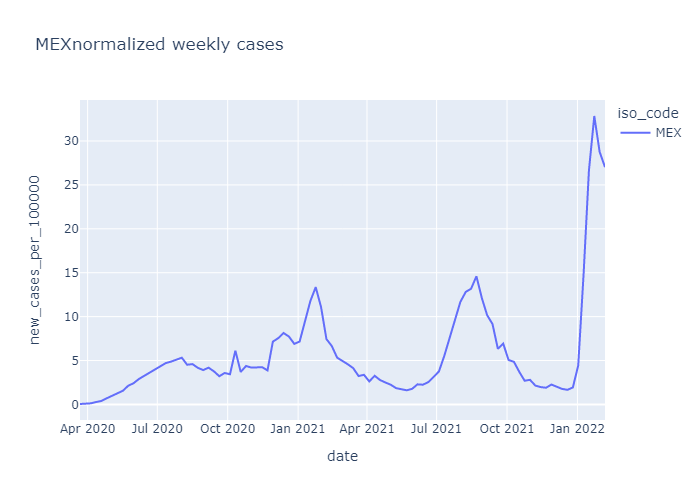

In [45]:
fig = px.line(dt_MEX_weekly_avg, x="date", y="new_cases_per_100000", color="iso_code",
              line_group="iso_code", hover_name="iso_code", title ='MEXnormalized weekly cases')
#display plot
fig.write_image("Team4/MMRnormalized weekly cases.png")
Image(filename="Team4/MMRnormalized weekly cases.png")
#fig.show()

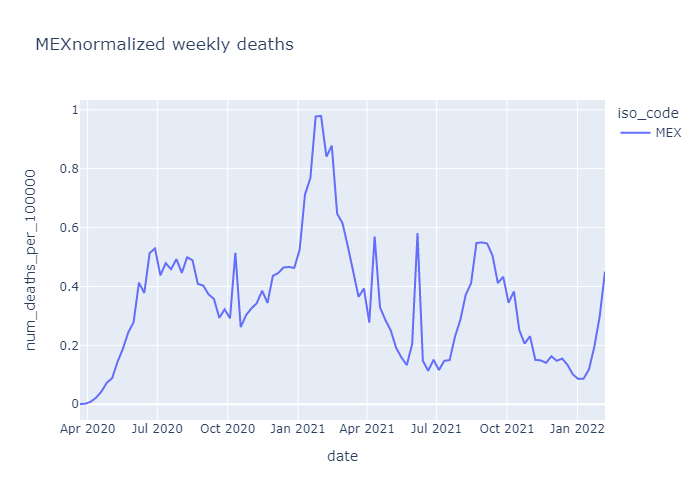

In [46]:
fig = px.line(dt_MEX_weekly_avg, x="date", y="num_deaths_per_100000", color="iso_code",
              line_group="iso_code", hover_name="iso_code", title ='MEXnormalized weekly deaths')
#display plot
fig.write_image("Team4/MEXnormalized weekly deaths.png")
Image(filename="Team4/MEXnormalized weekly deaths.png")
#fig.show()

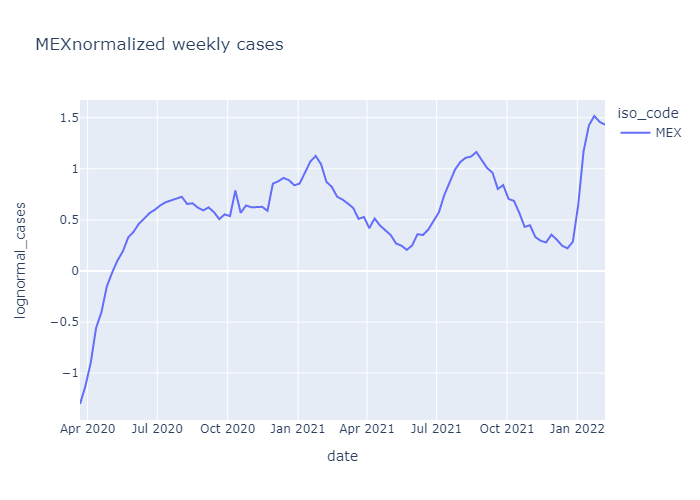

In [47]:
fig = px.line(dt_MEX_weekly_avg, x="date", y="lognormal_cases", color="iso_code",
              line_group="iso_code", hover_name="iso_code", title ='MEXnormalized weekly cases')
#display plot
fig.write_image("Team4/MEXnormalized weekly cases.png")
Image(filename="Team4/MEXnormalized weekly cases.png")
#fig.show()

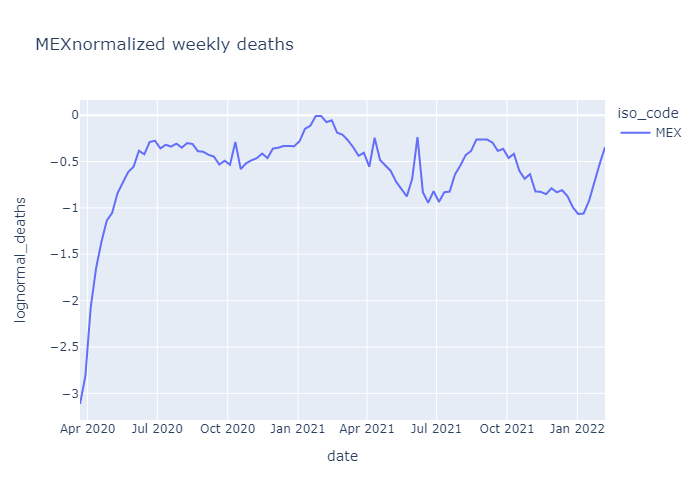

In [48]:
fig = px.line(dt_MEX_weekly_avg, x="date", y="lognormal_deaths", color="iso_code",
              line_group="iso_code", hover_name="iso_code", title ='MEXnormalized weekly deaths')
#display plot
fig.write_image("Team4/MEXnormalized weekly deaths.png")
Image(filename="Team4/MEXnormalized weekly deaths.png")
#fig.show()

## Inference from the plot:
### Mexico
* The first wave of Covid cases in Mexico was reported in August 2020. 
* The second wave which came in February 2021 was the most impactful in terms of confirmed Covid cases and reported deaths. Mexico city and the State of Mexico most impacted and were assigned red zone which resulted in strict lockdown regulations.
* The third wave of Covid cases was reported in September 2021. The government had lifted restrictions on social and Business activities which caused a high number of new cases in Covid.
* January 2022 had an impact due to the Omicron variant which spread throughout Mexico and caused a high number of Covid cases.
* The death count decreased since April 2021 as most of the citizens were vaccinated.


**Compiling data for Myanmar**

In [49]:
#subset data for DR Congo
dt_MMR = dt[dt['iso_code']=='MMR'].reset_index(drop=True)
#compute new cases each day
dt_MMR['new_cases'] = dt_MMR['total_cases'].diff()
#compute number of deaths each day
dt_MMR['num_deaths'] = dt_MMR['total_deaths'].diff()
#drop the date 03/21/2020
dt_MMR = dt_MMR.drop(0)
dt_MMR = dt_MMR.drop(columns=["total_cases", "total_deaths"])
MMR_pop = dt_MMR.population[1]
dt_MMR

,iso_code,location,date,population,population_density,new_cases,num_deaths
1,MMR,Myanmar,2020-03-28,54806014.0,81.721,0.0,NaN
2,MMR,Myanmar,2020-03-29,54806014.0,81.721,2.0,NaN
3,MMR,Myanmar,2020-03-30,54806014.0,81.721,4.0,NaN
4,MMR,Myanmar,2020-03-31,54806014.0,81.721,1.0,NaN
5,MMR,Myanmar,2020-04-01,54806014.0,81.721,0.0,0.0
...,...,...,...,...,...,...,...
676,MMR,Myanmar,2022-02-01,54806014.0,81.721,861.0,0.0
677,MMR,Myanmar,2022-02-02,54806014.0,81.721,143.0,0.0
678,MMR,Myanmar,2022-02-03,54806014.0,81.721,368.0,0.0
679,MMR,Myanmar,2022-02-04,54806014.0,81.721,319.0,0.0


In [50]:
#dt_MMR = dt_MMR.drop(columns=["population","population_density"]) 
#resampling to weekly data
dt_MMR_weekly_avg= dt_MMR.groupby(['iso_code','location',pd.Grouper(key='date', freq='w')])['new_cases','num_deaths'].agg({'new_cases':'mean','num_deaths' :'mean'}).reset_index().round(decimals=0)
dt_MMR_weekly_avg

,iso_code,location,date,new_cases,num_deaths
0,MMR,Myanmar,2020-03-29,1.0,NaN
1,MMR,Myanmar,2020-04-05,2.0,0.0
2,MMR,Myanmar,2020-04-12,3.0,0.0
3,MMR,Myanmar,2020-04-19,10.0,0.0
4,MMR,Myanmar,2020-04-26,5.0,0.0
...,...,...,...,...,...
93,MMR,Myanmar,2022-01-09,148.0,2.0
94,MMR,Myanmar,2022-01-16,155.0,2.0
95,MMR,Myanmar,2022-01-23,132.0,1.0
96,MMR,Myanmar,2022-01-30,169.0,0.0


In [51]:
dt_MMR_weekly_avg['new_cases_per_100000'] = dt_MMR_weekly_avg.new_cases/MMR_pop * 100000
dt_MMR_weekly_avg['num_deaths_per_100000'] = dt_MMR_weekly_avg.num_deaths/MMR_pop *100000
#log normalized values (base 10 log)
dt_MMR_weekly_avg['lognormal_cases'] = np.log10(dt_MMR_weekly_avg.new_cases_per_100000)
dt_MMR_weekly_avg['lognormal_deaths'] = np.log10(dt_MMR_weekly_avg.num_deaths_per_100000)
dt_MMR_weekly_avg.head()

,iso_code,location,date,new_cases,num_deaths,new_cases_per_100000,num_deaths_per_100000,lognormal_cases,lognormal_deaths
0,MMR,Myanmar,2020-03-29,1.0,NaN,0.001825,NaN,-2.738828,NaN
1,MMR,Myanmar,2020-04-05,2.0,0.0,0.003649,0.0,-2.437798,-inf
2,MMR,Myanmar,2020-04-12,3.0,0.0,0.005474,0.0,-2.261707,-inf
3,MMR,Myanmar,2020-04-19,10.0,0.0,0.018246,0.0,-1.738828,-inf
4,MMR,Myanmar,2020-04-26,5.0,0.0,0.009123,0.0,-2.039858,-inf


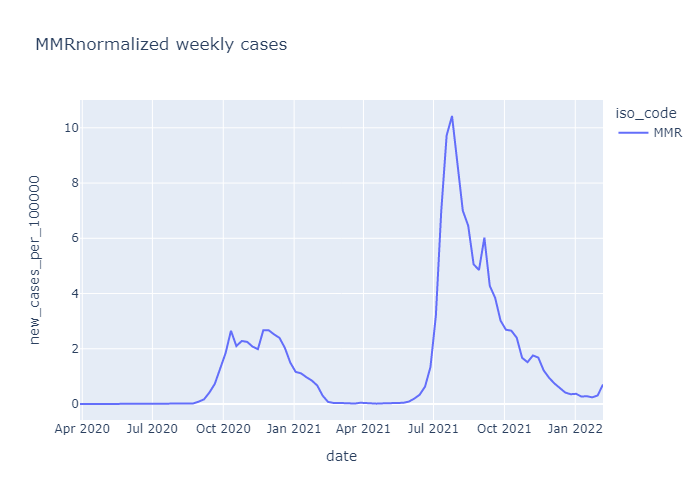

In [52]:
fig = px.line(dt_MMR_weekly_avg, x="date", y="new_cases_per_100000", color="iso_code",
              line_group="iso_code", hover_name="iso_code", title ='MMRnormalized weekly cases')
#display plot
fig.write_image("Team4/MMRnormalized weekly cases.png")
Image(filename="Team4/MMRnormalized weekly cases.png")
#fig.show()

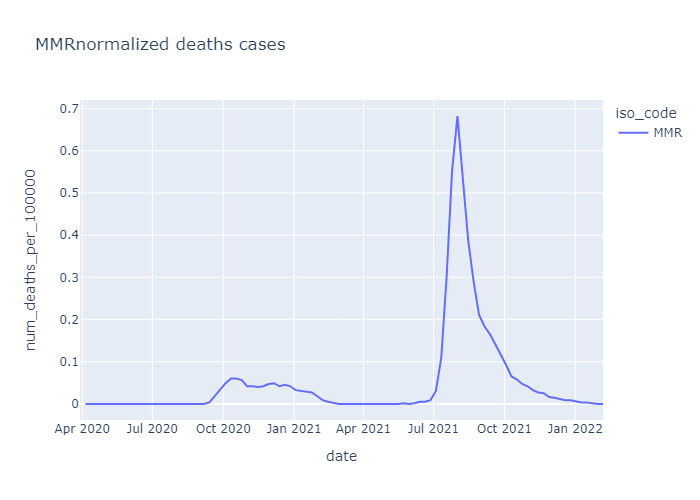

In [53]:
fig = px.line(dt_MMR_weekly_avg, x="date", y="num_deaths_per_100000", color="iso_code",
              line_group="iso_code", hover_name="iso_code", title ='MMRnormalized deaths cases')
#display plot
fig.write_image("Team4/MMRnormalized weekly deaths.png")
Image(filename="Team4/MMRnormalized weekly deaths.png")
#fig.show()

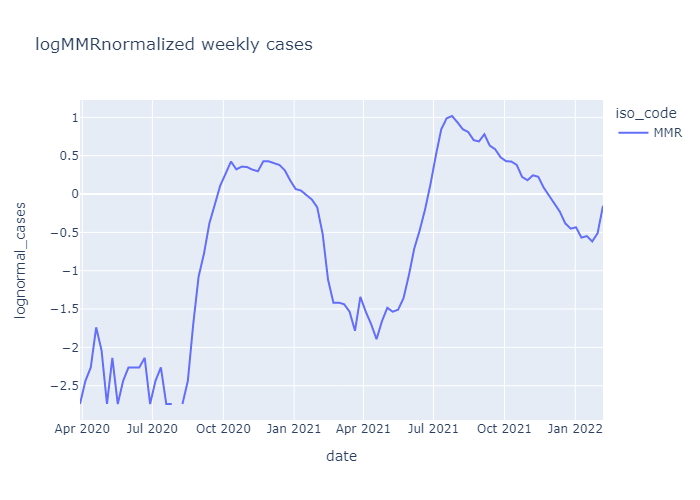

In [54]:
fig = px.line(dt_MMR_weekly_avg, x="date", y="lognormal_cases", color="iso_code",
              line_group="iso_code", hover_name="iso_code", title ='logMMRnormalized weekly cases')
#display plot
fig.write_image("Team4/logMMRnormalized weekly cases.png")
Image(filename="Team4/logMMRnormalized weekly cases.png")
#fig.show()

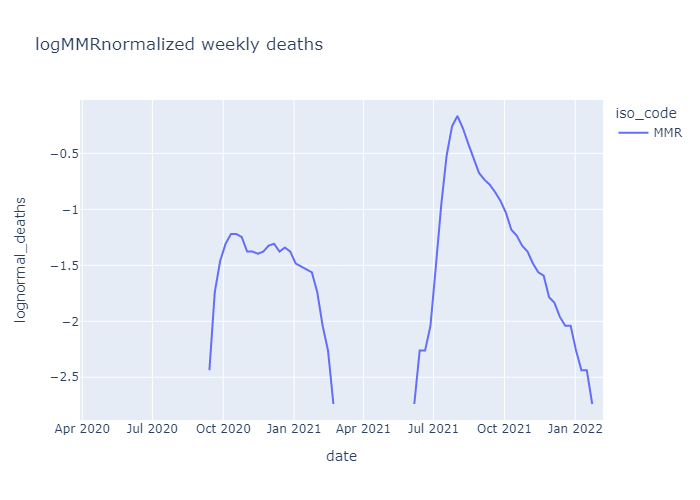

In [55]:
fig = px.line(dt_MMR_weekly_avg, x="date", y="lognormal_deaths", color="iso_code",
              line_group="iso_code", hover_name="iso_code", title ='logMMRnormalized weekly deaths')
#display plot
fig.write_image("Team4/logMMRnormalized weekly deaths.png")
Image(filename="Team4/logMMRnormalized weekly deaths.png")
#fig.show()

## Inference from the plot:
### Myanmar
* The first peak in covid cases occurred in the month of October 2020 because of the alpha/beta variant of covid. The peak occurred during the winter months in Myanmar and the same increase in the number of deaths can be seen.
* Myanmar lifted a few covid restrictions after the first wave and we can see a second covid wave in the month of July 2021 because of the spread of the Delta variant in Myanmar.
* Because of this, a huge peak can be seen in the number of cases/deaths in Myanmar, after which Myanmar imposed a strict lockdown and so cases started dropping by August 2021.
* In January a small number of cases can be seen because of the Omicron variant but nothing significant because of the high vaccination rate in Myanmar and covid restrictions. And so covid deaths is close to zero.
* Compared to the US, Myanmar shows early peaks in cases. Also there is no significant peaks in Myanmar compared to USA in Jan 2022. In case of deaths, there is no co-relation between USA and Myanmar. Myanmar has lower death rate than the USA in all the three covid waves. It has peak only during second covid wave(Delta variant).


**Compiling data for South Africa**

In [56]:
#subset data for DR Congo
dt_ZAF = dt[dt['iso_code']=='ZAF'].reset_index(drop=True)
#compute new cases each day
dt_ZAF['new_cases'] = dt_ZAF['total_cases'].diff()
#compute number of deaths each day
dt_ZAF['num_deaths'] = dt_ZAF['total_deaths'].diff()
#drop the date 03/21/2020
dt_ZAF = dt_ZAF.drop(0)
dt_ZAF = dt_ZAF.drop(columns=["total_cases", "total_deaths"])
ZAF_pop = dt_ZAF.population[1]
dt_ZAF

,iso_code,location,date,population,population_density,new_cases,num_deaths
1,ZAF,South Africa,2020-03-22,60041996.0,46.754,34.0,NaN
2,ZAF,South Africa,2020-03-23,60041996.0,46.754,128.0,NaN
3,ZAF,South Africa,2020-03-24,60041996.0,46.754,152.0,NaN
4,ZAF,South Africa,2020-03-25,60041996.0,46.754,155.0,NaN
5,ZAF,South Africa,2020-03-26,60041996.0,46.754,218.0,NaN
...,...,...,...,...,...,...,...
682,ZAF,South Africa,2022-02-01,60041996.0,46.754,3085.0,195.0
683,ZAF,South Africa,2022-02-02,60041996.0,46.754,4502.0,175.0
684,ZAF,South Africa,2022-02-03,60041996.0,46.754,3266.0,82.0
685,ZAF,South Africa,2022-02-04,60041996.0,46.754,0.0,0.0


In [57]:
dt_ZAF = dt_ZAF.drop(columns=["population","population_density"]) 
#resampling to weekly data
dt_ZAF_weekly_avg= dt_ZAF.groupby(['iso_code','location',pd.Grouper(key='date', freq='w')])['new_cases','num_deaths'].agg({'new_cases':'mean','num_deaths' :'mean'}).reset_index().round(decimals=0)
dt_ZAF_weekly_avg

,iso_code,location,date,new_cases,num_deaths
0,ZAF,South Africa,2020-03-22,34.0,NaN
1,ZAF,South Africa,2020-03-29,144.0,0.0
2,ZAF,South Africa,2020-04-05,54.0,1.0
3,ZAF,South Africa,2020-04-12,74.0,2.0
4,ZAF,South Africa,2020-04-19,141.0,4.0
...,...,...,...,...,...
94,ZAF,South Africa,2022-01-09,7660.0,175.0
95,ZAF,South Africa,2022-01-16,4748.0,130.0
96,ZAF,South Africa,2022-01-23,3152.0,116.0
97,ZAF,South Africa,2022-01-30,3214.0,121.0


In [58]:
dt_ZAF_weekly_avg['new_cases_per_100000'] = dt_ZAF_weekly_avg.new_cases/ZAF_pop *100000
dt_ZAF_weekly_avg['num_deaths_per_100000'] = dt_ZAF_weekly_avg.num_deaths/ZAF_pop *100000
#log normalized values (base 10 log)
dt_ZAF_weekly_avg['lognormal_cases'] = np.log10(dt_ZAF_weekly_avg.new_cases_per_100000)
dt_ZAF_weekly_avg['lognormal_deaths'] = np.log10(dt_ZAF_weekly_avg.num_deaths_per_100000)
dt_ZAF_weekly_avg.head()

,iso_code,location,date,new_cases,num_deaths,new_cases_per_100000,num_deaths_per_100000,lognormal_cases,lognormal_deaths
0,ZAF,South Africa,2020-03-22,34.0,NaN,0.056627,NaN,-1.246976,NaN
1,ZAF,South Africa,2020-03-29,144.0,0.0,0.239832,0.000000,-0.620093,-inf
2,ZAF,South Africa,2020-04-05,54.0,1.0,0.089937,0.001666,-1.046061,-2.778455
3,ZAF,South Africa,2020-04-12,74.0,2.0,0.123247,0.003331,-0.909223,-2.477425
4,ZAF,South Africa,2020-04-19,141.0,4.0,0.234836,0.006662,-0.629236,-2.176395


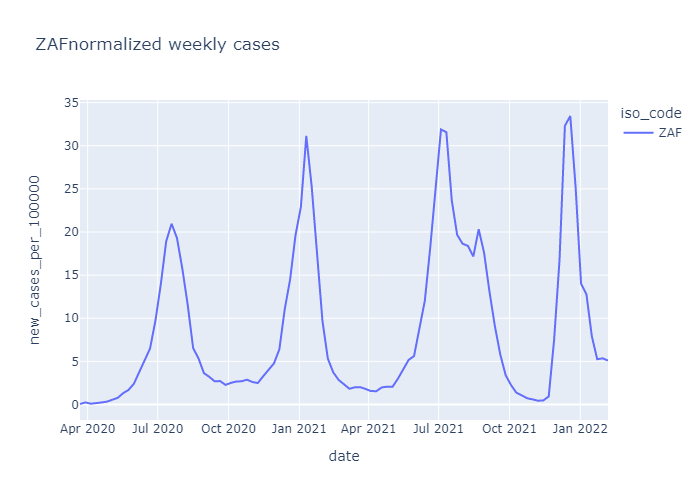

In [59]:
fig = px.line(dt_ZAF_weekly_avg, x="date", y="new_cases_per_100000", color="iso_code",
              line_group="iso_code", hover_name="iso_code", title ='ZAFnormalized weekly cases')
#display plot
fig.write_image("Team4/ZAFnormalized weekly cases.png")
Image(filename="Team4/ZAFnormalized weekly cases.png")
#fig.show()

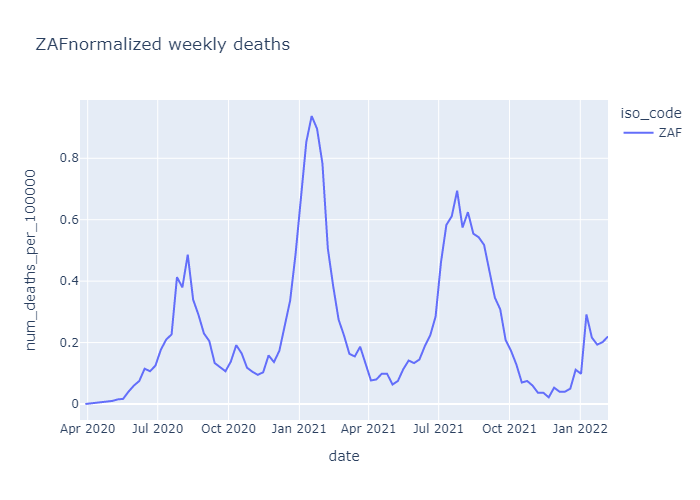

In [60]:
fig = px.line(dt_ZAF_weekly_avg, x="date", y="num_deaths_per_100000", color="iso_code",
              line_group="iso_code", hover_name="iso_code", title ='ZAFnormalized weekly deaths')
#display plot
fig.write_image("Team4/ZAFnormalized weekly cases.png")
Image(filename="Team4/ZAFnormalized weekly cases.png")
#fig.show()

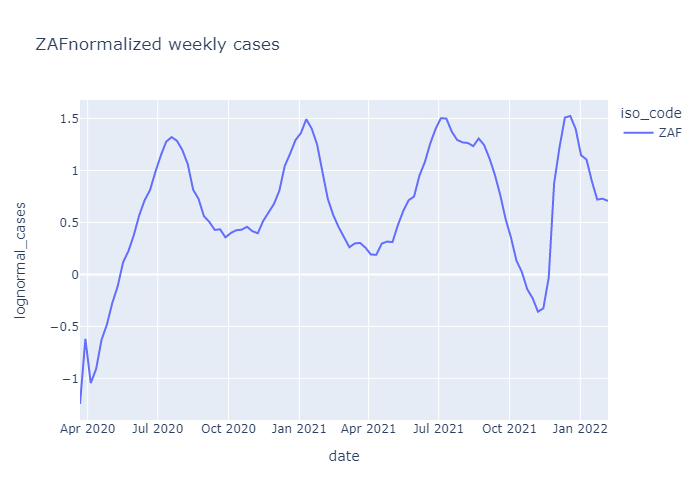

In [61]:
fig = px.line(dt_ZAF_weekly_avg, x="date", y="lognormal_cases", color="iso_code",
              line_group="iso_code", hover_name="iso_code", title ='ZAFnormalized weekly cases')
#display plot
fig.write_image("Team4/ZAFnormalized weekly cases.png")
Image(filename="Team4/ZAFnormalized weekly cases.png")
#fig.show()

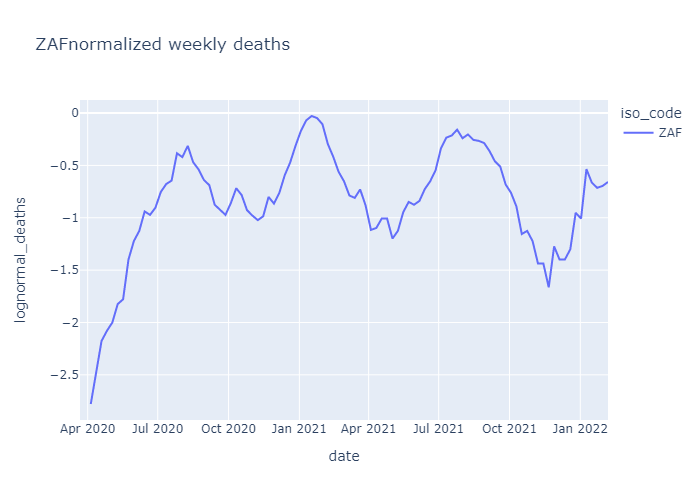

In [62]:
fig = px.line(dt_ZAF_weekly_avg, x="date", y="lognormal_deaths", color="iso_code",
              line_group="iso_code", hover_name="iso_code", title ='ZAFnormalized weekly deaths')
#display plot
fig.write_image("Team4/ZAFnormalized weekly deaths.png")
Image(filename="Team4/ZAFnormalized weekly deaths.png")
#fig.show()

## Inference from the plots:
### South Africa
* Peaks were observed in the month of August 2020 , Jan 2021 , August 2021 and again in the month of Jan 2022. 
* In Aug 2020 , It was the first wave of covid and thus there was an increase in the number of cases. 
* In Jan 2021, there was sudden increase in the number of cases and reason is social gathering. It was that time of the year    where people want to meet their families and celebrate ThanksGiving , Christmas and New Year together. This is one reason      for increase in COVID cases. Also, 501.V2 a new covid variant was discovered and until then no vaccination had started for      the local people. By the end of January, the vaccine was imported from India to prevent the spread of the virus. But the        research says that the main reason for the outbreak is related to the new variant or a lack of compliance with health guidelines    during the holiday period.
* In August 2021, the third wave of covid broke and this led to multiple variants of covid in the country which were highly   transmissible( Delta variant). The President declared the system was beyond its breaking point, with insufficient beds and barely enough oxygen which led to more deaths. 
* In Jan 2022, there was an outbreak for OMICRON virus which led to the increase in the number of cases.


**Compiling data for Spain**

In [63]:
#subset data for DR Congo
dt_ESP = dt[dt['iso_code']=='ESP'].reset_index(drop=True)
#compute new cases each day
dt_ESP['new_cases'] = dt_ESP['total_cases'].diff()
#compute number of deaths each day
dt_ESP['num_deaths'] = dt_ESP['total_deaths'].diff()
#drop the date 03/21/2020
dt_ESP = dt_ESP.drop(0)
dt_ESP = dt_ESP.drop(columns=["total_cases", "total_deaths"])
ESP_pop = dt_ESP.population[1]
dt_ESP

,iso_code,location,date,population,population_density,new_cases,num_deaths
1,ESP,Spain,2020-03-22,46745211.0,93.105,3394.0,397.0
2,ESP,Spain,2020-03-23,46745211.0,93.105,6368.0,539.0
3,ESP,Spain,2020-03-24,46745211.0,93.105,4749.0,497.0
4,ESP,Spain,2020-03-25,46745211.0,93.105,9630.0,839.0
5,ESP,Spain,2020-03-26,46745211.0,93.105,8271.0,718.0
...,...,...,...,...,...,...,...
682,ESP,Spain,2022-02-01,46745211.0,93.105,77873.0,408.0
683,ESP,Spain,2022-02-02,46745211.0,93.105,86222.0,224.0
684,ESP,Spain,2022-02-03,46745211.0,93.105,74368.0,183.0
685,ESP,Spain,2022-02-04,46745211.0,93.105,0.0,0.0


In [64]:
dt_ESP = dt_ESP.drop(columns=["population","population_density"]) 
#resampling to weekly data
dt_ESP_weekly_avg= dt_ESP.groupby(['iso_code','location',pd.Grouper(key='date', freq='w')])['new_cases','num_deaths'].agg({'new_cases':'mean','num_deaths' :'mean'}).reset_index().round(decimals=0)
dt_ESP_weekly_avg

,iso_code,location,date,new_cases,num_deaths
0,ESP,Spain,2020-03-22,3394.0,397.0
1,ESP,Spain,2020-03-29,7335.0,719.0
2,ESP,Spain,2020-04-05,7362.0,834.0
3,ESP,Spain,2020-04-12,5026.0,653.0
4,ESP,Spain,2020-04-19,4549.0,463.0
...,...,...,...,...,...
94,ESP,Spain,2022-01-09,124309.0,76.0
95,ESP,Spain,2022-01-16,132590.0,118.0
96,ESP,Spain,2022-01-23,126060.0,140.0
97,ESP,Spain,2022-01-30,114810.0,175.0


In [65]:
dt_ESP_weekly_avg['new_cases_per_100000'] = dt_ESP_weekly_avg.new_cases/ESP_pop *100000
dt_ESP_weekly_avg['num_deaths_per_100000'] = dt_ESP_weekly_avg.num_deaths/ESP_pop *100000
#log normalized values (base 10 log)
dt_ESP_weekly_avg['lognormal_cases'] = np.log10(dt_ESP_weekly_avg.new_cases_per_100000)
dt_ESP_weekly_avg['lognormal_deaths'] = np.log10(dt_ESP_weekly_avg.num_deaths_per_100000)
dt_ESP_weekly_avg.head()

,iso_code,location,date,new_cases,num_deaths,new_cases_per_100000,num_deaths_per_100000,lognormal_cases,lognormal_deaths
0,ESP,Spain,2020-03-22,3394.0,397.0,7.260637,0.849285,0.860975,-0.070947
1,ESP,Spain,2020-03-29,7335.0,719.0,15.691447,1.538125,1.195663,0.186992
2,ESP,Spain,2020-04-05,7362.0,834.0,15.749207,1.784140,1.197259,0.251429
3,ESP,Spain,2020-04-12,5026.0,653.0,10.751904,1.396935,1.031485,0.145176
4,ESP,Spain,2020-04-19,4549.0,463.0,9.731478,0.990476,0.988179,-0.004156


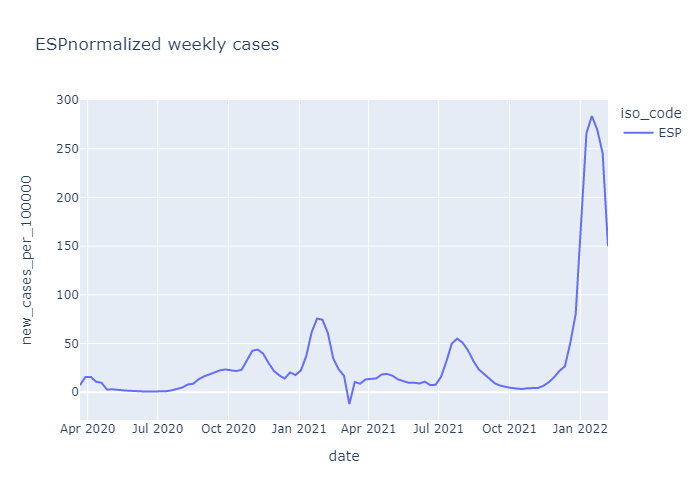

In [66]:
fig = px.line(dt_ESP_weekly_avg, x="date", y="new_cases_per_100000", color="iso_code",
              line_group="iso_code", hover_name="iso_code", title ='ESPnormalized weekly cases')

#display plot
fig.write_image("Team4/ESPnormalized weekly cases.png")
Image(filename="Team4/ESPnormalized weekly cases.png")
#fig.show()

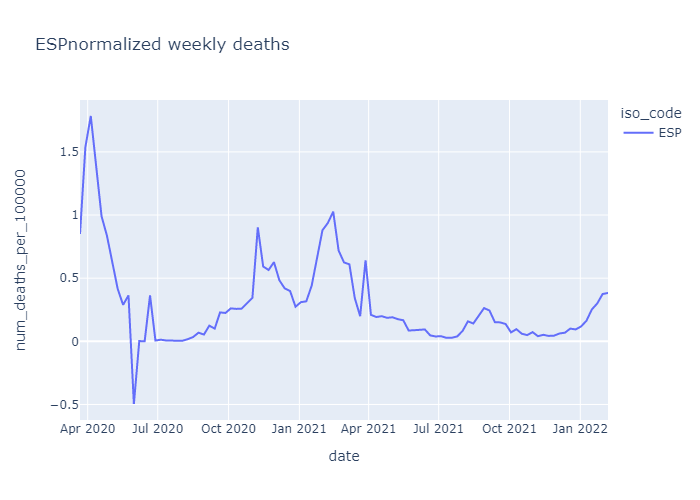

In [67]:
fig = px.line(dt_ESP_weekly_avg, x="date", y="num_deaths_per_100000", color="iso_code",
              line_group="iso_code", hover_name="iso_code", title ='ESPnormalized weekly deaths')

#display plot
fig.write_image("Team4/ESPnormalized weekly deaths cases.png")
Image(filename="Team4/ESPnormalized weekly deaths cases.png")
#fig.show()

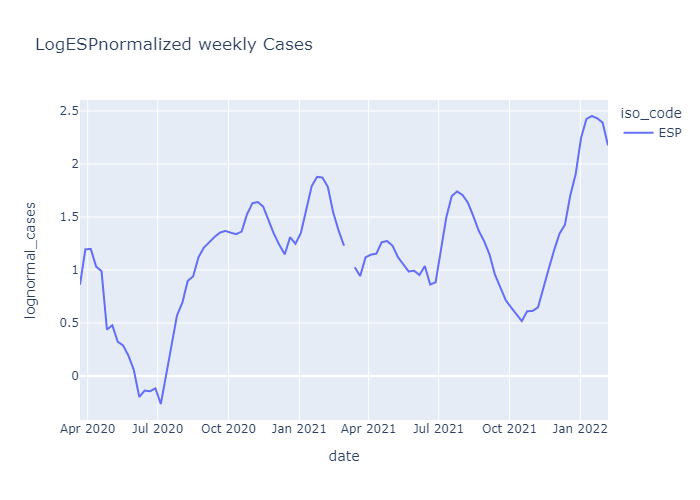

In [68]:
fig = px.line(dt_ESP_weekly_avg, x="date", y="lognormal_cases", color="iso_code",
              line_group="iso_code", hover_name="iso_code", title ='LogESPnormalized weekly Cases')

#display plot
fig.write_image("Team4/logESPnormalized weekly cases.png")
Image(filename="Team4/logESPnormalized weekly cases.png")
#fig.show()

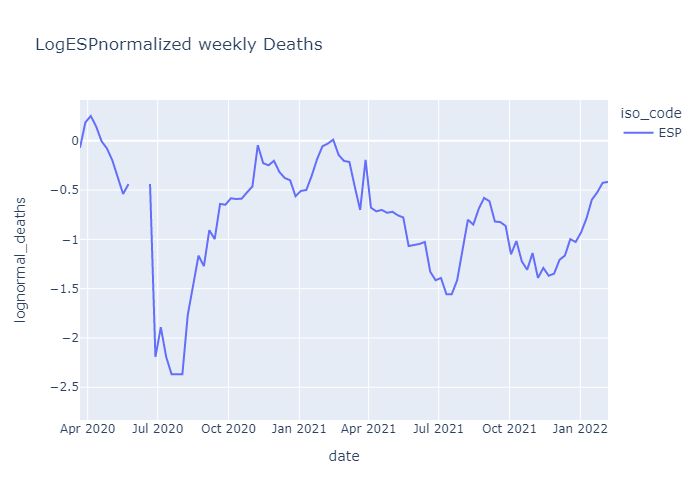

In [69]:
fig = px.line(dt_ESP_weekly_avg, x="date", y="lognormal_deaths", color="iso_code",
              line_group="iso_code", hover_name="iso_code", title ='LogESPnormalized weekly Deaths')

#display plot
fig.write_image("Team4/logESPnormalized weekly deaths.png")
Image(filename="Team4/logESPnormalized weekly deaths.png")
#fig.show()

## Inference from the plot:
### Spain
* Spain mirrors the US in many ways in terms of when it spikes and dips in cases, due to things like holidays and the Delta/Omicron variants. It does appear that the spike due to Delta occurs slightly earlier than in the US. We know that countries like the UK were hit with the Delta variant earlier, so it’s possible that it spread to other European nations slightly faster than to the US. What does differ is the deaths. 
* Spain appears to have fewer spikes in COVID deaths, and outside of the first spike when the outbreak began, its spikes appear much more muddled. This appears to be especially true for the Delta and Omicron variant case spikes, where the deaths could arguably be said to not spike at all. For Delta, it’s not certain why the deaths are lower than in other countries. 
* The country did impose restrictions on gatherings and stated that people should only leave their homes if necessary, but nothing concrete as to why deaths did not spike to the same extent. However, for Omicron it could be attributed to vaccination rates. By the time Omicron hit Spain, over 80% of citizens were vaccinated. Vaccinations, when Delta hit, were about 66%, which is higher than countries like the US, but not majorly so.